<a href="https://colab.research.google.com/github/tomo0530/CS699_Term_Project/blob/master/CS699_Term_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predict hits in Japanese Baseball

# Initialization

Mount google drive for file storage.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Install pycaret and xfeat

In [ ]:
!pip install pycaret

In [ ]:
!pip install xfeat

Enable pycaret on colab

In [ ]:
from pycaret.utils import enable_colab
enable_colab()

Install some packages

In [92]:
import numpy as np
import pandas as pd
from pandas.core.common import random_state
from IPython.display import display, HTML, Markdown
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import VarianceThreshold
from pycaret.classification import *
from xfeat import CountEncoder, TargetEncoder

Download pre-processed data

In [150]:
df = pd.read_csv('https://raw.githubusercontent.com/tomo0530/CS699_Term_Project/master/baseball_info.csv')
df.columns

Index(['totalPitchingCount', 'B', 'S', 'O', 'b1', 'b2', 'b3', 'pitcher',
       'pitcherHand', 'batter', 'batterHand', 'pitchType', 'speed', 'ballX',
       'ballY', 'y', 'inning_number', 'inning_tb', 'batter_isPitcher',
       'ballWidthLabel', 'ballHeightLabel', 'pitch_category', 'bottomTeam',
       'topTeam', 'place', 'minute', 'hour', 'day', 'month', 'year',
       'day_of_week', 'day_of_year', 'pitcher_order', 'batter_order'],
      dtype='object')

Split data into train and test

In [151]:
df_train, df_test = train_test_split(df, test_size=0.34, random_state=123, stratify=df['y'])

Count and Target encoding for categorical features

In [152]:
# list categorical columns
categorical_columns = [x for x in df.columns if df[x].dtypes == 'object']

# count encoding
count_encoder = CountEncoder(input_cols=categorical_columns)
df_train = count_encoder.fit_transform(df_train)
df_test = count_encoder.transform(df_test)

# target encoding
fold = KFold(n_splits=10, shuffle=True, random_state=123)
target_encoder = TargetEncoder(input_cols=categorical_columns, target_col='y', fold=fold)
df_train = target_encoder.fit_transform(df_train)
df_test = target_encoder.transform(df_test)

# drop original categorical columns
df_train = df_train.drop(categorical_columns, axis=1)
df_train = df_test.drop(categorical_columns, axis=1)

Save train and test data

In [153]:
df_train.to_csv('/content/drive/MyDrive/CS699_TermProject/train_data.csv', index=False)
df_test.to_csv('/content/drive/MyDrive/CS699_TermProject/test_data.csv', index=False)

Split into objective and explanatory variables

In [154]:
X_train, y_train = df_train.drop('y', axis=1), df_train['y'].values
X_test, y_test = df_test.drop('y', axis=1), df_test['y'].values

# Classification

## All attributes

Setup pycaret with all attributes

In [ ]:
clf = setup(data=df_train, target='y', session_id=123,
            categorical_features = ['ballX'],
            numeric_features = ['pitchType_ce'])

Compare all classification algorithms.    
Sorting by MCC because the proportion of "1" (hit) is extremely low.

In [157]:
best_model = compare_models(sort='MCC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9491,0.7173,0.0951,1.0000,0.1720,0.1641,0.2955,0.828
et,Extra Trees Classifier,0.9491,0.7056,0.0951,1.0000,0.1720,0.1641,0.2955,0.966
lightgbm,Light Gradient Boosting Machine,0.9471,0.7441,0.0951,0.7117,0.1665,0.1557,0.2456,0.220
nb,Naive Bayes,0.6161,0.7440,0.7836,0.1062,0.1871,0.0977,0.1824,0.037
dt,Decision Tree Classifier,0.8983,0.5587,0.1761,0.1518,0.1620,0.1086,0.1093,0.075
ada,Ada Boost Classifier,0.9444,0.7395,0.0110,0.3000,0.0212,0.0201,0.0558,0.376
lr,Logistic Regression,0.9440,0.7357,0.0108,0.3000,0.0209,0.0190,0.0532,0.949
qda,Quadratic Discriminant Analysis,0.5240,0.5393,0.5566,0.0657,0.1171,0.0186,0.0368,0.116
knn,K Neighbors Classifier,0.9405,0.5429,0.0144,0.1867,0.0261,0.0174,0.0344,0.213
svm,SVM - Linear Kernel,0.9196,0.0000,0.0517,0.0671,0.0276,0.0160,0.0247,0.123


Tune the best algorithm and Evaluate the training result by some plots.

In [158]:
tuned_model = tune_model(best_model, optimize='MCC')
evaluate_model(tuned_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6811,0.7648,0.6667,0.1098,0.1885,0.1029,0.1689
1,0.6790,0.7178,0.5556,0.0943,0.1613,0.0733,0.1181
2,0.6831,0.7709,0.7500,0.1250,0.2143,0.1282,0.2102
3,0.6440,0.7558,0.6429,0.0994,0.1722,0.0805,0.1383
4,0.6420,0.7084,0.6429,0.0989,0.1714,0.0795,0.1371
5,0.6907,0.7732,0.7037,0.1180,0.2021,0.1180,0.1917
6,0.6742,0.7901,0.7407,0.1170,0.2020,0.1171,0.1973
7,0.6907,0.7683,0.7778,0.1273,0.2187,0.1361,0.2242
8,0.6804,0.7196,0.7407,0.1190,0.2051,0.1208,0.2012
9,0.6742,0.7166,0.6667,0.1078,0.1856,0.0992,0.1647


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

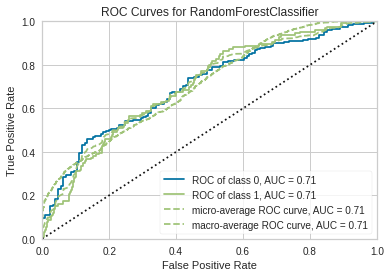

In [159]:
plot_model(tuned_model, plot='auc')

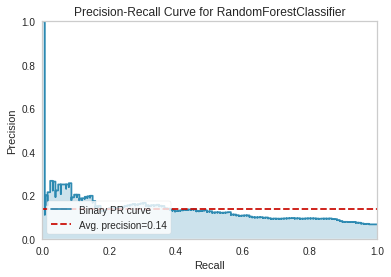

In [160]:
plot_model(tuned_model, plot = 'pr')

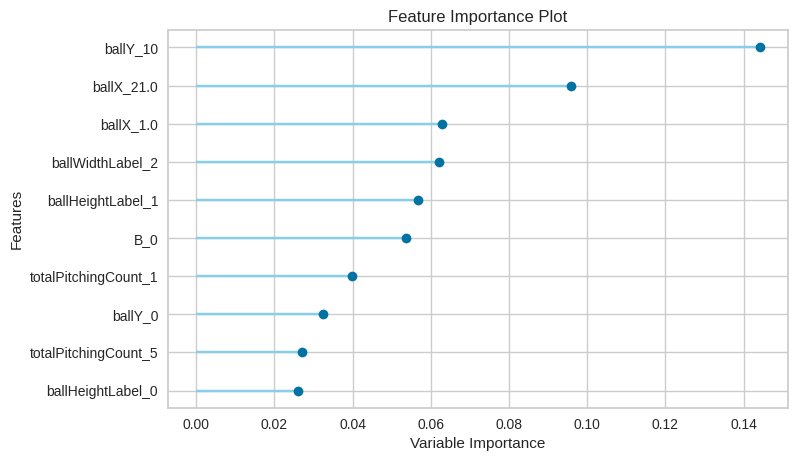

In [161]:
plot_model(tuned_model, plot = 'feature')

Create a final model for prediction.    
Predict labels using test data.

In [162]:
final_model = finalize_model(tuned_model)
test_pred = predict_model(final_model, data=X_test, raw_score=True)

Create a function to evaluate classifier using predicted result and actual test data.


In [163]:
def evaluate_accuracy(y_test, test_pred):
  y_pred = test_pred['Label'].values
  y_pred_1 = np.where(y_pred == 0, 1, 0)
  test_score = test_pred['Score_1'].values

  prc = classification_report(y_test, y_pred, output_dict=True)
  mc = matthews_corrcoef(y_test, y_pred)
  roc_area = roc_auc_score(y_test, test_score)
  precision, recall, _ = precision_recall_curve(y_test, test_score)
  prc_area = auc(recall, precision)  

  cls = ['0', '1', 'Weighted Avg.']
  tpr = [prc['0']['recall'], prc['1']['recall'], prc['weighted avg']['recall']]
  fpr = [1 - tpr[i] for i in range(len(tpr))]
  pre = [prc['0']['precision'], prc['1']['precision'], prc['weighted avg']['precision']]
  rec = tpr
  fm = [prc['0']['f1-score'], prc['1']['f1-score'], prc['weighted avg']['f1-score']]
  mcc = [mc, mc, mc]
  roc = [roc_area, roc_area, roc_area]
  prc = [prc_area, prc_area, prc_area]
  
  data = {
            'Class': cls,
            'TP Rate': tpr,
            'FP Rate': fpr,
            'Precision': pre,
            'Recall': rec,
            'F-Measure': fm,
            'MCC': mcc,
            'ROC Area': roc,
            'PRC Area': prc
        }
  
  return pd.DataFrame(data)


Evaluate predicted result.

In [164]:
df_eval = evaluate_accuracy(y_test, test_pred)
df_eval

,Class,TP Rate,FP Rate,Precision,Recall,F-Measure,MCC,ROC Area,PRC Area
0,0,0.663659,0.336341,0.978575,0.663659,0.790922,0.206322,0.788799,0.230086
1,1,0.761905,0.238095,0.121454,0.761905,0.209511,0.206322,0.788799,0.230086
2,Weighted Avg.,0.669309,0.330691,0.929275,0.669309,0.757481,0.206322,0.788799,0.230086


## Attribute selection method

Using the top 5 classifiers obtained from the classifier comparison above, create a function for tuning with training data, making predictions from test data, and evaluating prediction results.

In [165]:
def evaluate_each_clf_accuracy(df_train, X_test, y_test, optimize='Accuracy'):
  clf_dict = {'rf':	'Random Forest Classifier',
              'et': 'Extra Trees Classifier',
              'lightgbm':	'Light Gradient Boosting Machine',
              'nb':	'Naive Bayes',
              'dt':	'Decision Tree Classifier'}

  original_list_c = ['ballX']
  original_list_n = ['pitchType_ce']
  c_list = [i for i in df_train.columns if i in original_list_c]
  n_list = [i for i in df_train.columns if i in original_list_n]
  clf = setup(data=df_train, target='y', session_id=123, 
              categorical_features = c_list, 
              numeric_features = n_list, silent = True)  
  
  df = pd.DataFrame()
  for model, name in clf_dict.items():
    m = create_model(model)
    tuned_m = tune_model(m, optimize=optimize)
    final_m = finalize_model(tuned_m)
    test_pred = predict_model(final_m, data=X_test, raw_score=True)
    df_new = evaluate_accuracy(y_test, test_pred)
    df_new['Model'] = name
    df = pd.concat([df, df_new])
  
  return df.set_index(["Model", "Class"])

Set the number to select attributes.

In [166]:
k = 5

### Filter method (variance threshold)

In [171]:
threshold = 30
sel = VarianceThreshold(threshold=threshold)
sel.fit_transform(X_train)
X_new = pd.DataFrame(sel.fit_transform(X_train), columns=X_train.columns.values[sel.get_support()])
print('Before Feature Selection:', X_train.shape)
print('After Feature Selection:', X_new.shape)
new_col = X_train.columns[sel.get_support()]
print('Selected attribute: ', new_col.to_list())

Before Feature Selection: (6937, 36)
After Feature Selection: (6937, 5)
Selected attribute:  ['speed', 'ballX', 'pitcher_ce', 'batter_ce', 'pitchType_ce']


In [ ]:
df_train_new = X_train[new_col]
df_train_new['y'] = df_train['y']
X_test_new = X_test[new_col]
df_eval = evaluate_each_clf_accuracy(df_train_new, X_test_new, y_test, optimize='MCC')

In [173]:
style = (df_eval.style.highlight_min(color="green").highlight_max(color="red"))  
display(style)

### Filter method (chi-squared test)

In [175]:
selector = SelectKBest(chi2, k=k)
selector.fit_transform(X_train, y_train)
new_col = X_train.columns[selector.get_support()]
print('Selected attribute: ', new_col.to_list())

Selected attribute:  ['totalPitchingCount', 'B', 'pitcher_ce', 'batter_ce', 'pitchType_ce']


In [ ]:
df_train_new = X_train[new_col]
df_train_new['y'] = df_train['y']
X_test_new = X_test[new_col]
df_eval = evaluate_each_clf_accuracy(df_train_new, X_test_new, y_test, optimize='MCC')

In [177]:
style = (df_eval.style.highlight_min(color="green").highlight_max(color="red"))  
display(style)

### Filter method (ANOVA)

In [178]:
selector = SelectKBest(f_classif, k=k)
selector.fit_transform(X_train, y_train)
new_col = X_train.columns[selector.get_support()]
print('Selected attribute: ', new_col.to_list())

Selected attribute:  ['totalPitchingCount', 'B', 'S', 'pitcher_ce', 'pitchType_te']


In [ ]:
df_train_new = X_train[new_col]
df_train_new['y'] = df_train['y']
X_test_new = X_test[new_col]
df_eval = evaluate_each_clf_accuracy(df_train_new, X_test_new, y_test, optimize='MCC')

In [180]:
style = (df_eval.style.highlight_min(color="green").highlight_max(color="red"))  
display(style)

### Filter method (mutual information)

In [181]:
selector = SelectKBest(mutual_info_classif, k=k)
selector.fit_transform(X_train, y_train)
new_col = X_train.columns[selector.get_support()]
print('Selected attribute: ', new_col.to_list())

Selected attribute:  ['totalPitchingCount', 'ballX', 'ballY', 'place', 'pitcher_ce']


In [ ]:
df_train_new = X_train[new_col]
df_train_new['y'] = df_train['y']
X_test_new = X_test[new_col]
df_eval = evaluate_each_clf_accuracy(df_train_new, X_test_new, y_test, optimize='MCC')

In [183]:
style = (df_eval.style.highlight_min(color="green").highlight_max(color="red"))  
display(style)

### Wrapper method

Remove attributes with variance of 0

In [184]:
sel = VarianceThreshold()
X = pd.DataFrame(sel.fit_transform(X_train), columns=X_train.columns.values[sel.get_support()])

Use Random Forest and recursive feature elimination

In [185]:
rf = RandomForestClassifier()
selector = RFE(rf, n_features_to_select=k)
selector.fit_transform(X, y_train)
new_col = X.columns[selector.get_support()]
print('Selected attribute: ', new_col.to_list())

Selected attribute:  ['speed', 'ballX', 'batter_ce', 'pitcher_te', 'batter_te']


In [ ]:
df_train_new = X_train[new_col]
df_train_new['y'] = df_train['y']
X_test_new = X_test[new_col]
df_eval = evaluate_each_clf_accuracy(df_train_new, X_test_new, y_test, optimize='MCC')

In [187]:
style = (df_eval.style.highlight_min(color="green").highlight_max(color="red"))  
display(style)

Save train and test data that were used for the best model.

In [188]:
best_selector = RFE(rf, n_features_to_select=k)
best_selector.fit_transform(X_train, y_train)
new_col_best = X_train.columns[best_selector.get_support()]
df_train_new = X_train[new_col_best]
X_test_new = X_test[new_col_best]

df_train_new.to_csv('/content/drive/MyDrive/CS699_TermProject/train_data_best.csv', index=False)
X_test_new.to_csv('/content/drive/MyDrive/CS699_TermProject/test_data_best.csv', index=False)